In [1]:
import sys
sys.path.append('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPeper')
import os.path
import pickle


import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import keras
from keras import backend as K
from keras.models import Sequential,model_from_json
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.constraints import max_norm
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
from keras.losses import binary_crossentropy,mean_squared_error
from imblearn.over_sampling import SMOTE, ADASYN


from technicalSignals import Indicators





#CPU RUN
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/simone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
technical_feat = True
kind_of_dataset = 'AffectiveSpace'
NN_INPUT_DIM = 716

In [3]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
        cum_ret_test = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = Indicators.momentum(price, 30)
            price['mom_50'] = Indicators.momentum(price, 50)
            price['mom_100'] = Indicators.momentum(price, 100)
            price['mom_150'] = Indicators.momentum(price, 150)
            price['SMA_30'] = Indicators.SMA(price, 30)
            price['SMA_50'] = Indicators.SMA(price, 50)
            price['SMA_100'] = Indicators.SMA(price, 100)
            price['SMA_150'] = Indicators.SMA(price, 150)
            price['in_BBands'] = Indicators.inBBands(price)
            price['eccessVolumes'] = Indicators.eccessOfVolumes(price)


        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 20, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150',
                                  'SMA_30','SMA_50','SMA_100','SMA_150','in_BBands', 'eccessVolumes']
            X = pd.concat([X, price[technical_features]],axis=1)


        #NORMALIZATION:
        with open('min_max_scaler_trained_allTickers_VolumeFeature.pickle', 'rb') as handle:
            min_max_scaler = pickle.load(handle)
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        self.cum_ret_test = []
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            s =np.sign(cumulative_return)
            y.append(0 if s==-1 else 1)
            self.cum_ret_test.append(cumulative_return)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])

        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        self.cum_ret_test =  self.cum_ret_test[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    
    def normalize(self, values):
        m = min(values)
        M = max(values)
        values = 2*(values-m)/(M-m)-1
        return values
    
    def get_dataset_for_trend_all_tickers(self, init, finish,kind, perc_train = 0.7, technicalFeatures=False):
        x_tv_all = []
        y_tv_all = []
        x_test_all = []
        y_test_all = []
        dates_test_prev = None
        for ticker in tickers:
            self.load_dataset(ticker, kind, technicalFeatures)
            (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
            if(dates_test_prev):
                assert dates_test == dates_test_prev #I'm not secure about this constraint but otherwise which dates I will output?
            x_tv_all += x_tv.tolist()
            y_tv_all += y_tv.tolist()
            x_test_all += x_test.tolist()
            y_test_all += y_test.tolist()
        x_tv_all = np.asarray(x_tv_all)
        y_tv_all = np.asarray(y_tv_all)
        x_test_all = np.asarray(x_test_all)
        y_test_all = np.asarray(y_test_all)
        return (x_tv_all,y_tv_all),(x_test_all,y_test_all), dates_test
    
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled

In [8]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def plot_hystory(history,l2,drop,n_units):
    f, axarr = plt.subplots(2, sharex=True)
    f.set_figheight(7)
    f.set_figwidth(10)
    axarr[0].plot(history.history['acc'],'g', label='accuracy_train')
    axarr[0].plot(history.history['val_acc'],'r', label='accuracy_val')
    axarr[1].semilogy(history.history['loss'],'g',label='loss_train')
    axarr[1].semilogy(history.history['val_loss'],'r',label='loss_val')
    #axarr[1].set_ylim([0,2])
    axarr[1].legend()   
    axarr[0].legend()   
    axarr[0].set_title('l2: '+str(l2)+' drop: '+str(drop)+' n_units: '+str(n_units))   
    plt.show() 
            
def get_pretrained_model(init, finish):
    json_file = open('pretraining_weights/nn_model_'+str(init)+'_'+str(finish)+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    nn_model.load_weights('pretraining_weights/nn_model_pretrained_weights_all_tickers_REGR_'+str(init)+'_'+str(finish)+'.h5')
    #All layers not trainable except last one
    i=0
    while nn_model.get_layer(index=i) != nn_model.get_layer(index=-1):
        nn_model.get_layer(index=i).trainable = False
        i +=1
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    nn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', matthews_correlation])
    return nn_model

    
def best_num_epoch(x_tv,y_tv):
    nn_model = get_pretrained_model(init, finish)
    trainpoint=math.floor(len(x_tv)*0.7)
    x_train=x_tv[0:trainpoint]
    y_train=y_tv[0:trainpoint]
    x_val=x_tv[trainpoint:]
    y_val=y_tv[trainpoint:]
    (x_train,y_train) = smote(x_train,y_train)
    
    history = nn_model.fit(x_train, y_train, epochs = 200,batch_size =256, verbose=0, 
                           validation_data=(x_val, y_val),shuffle=True)
    best_epoch = np.argmax(np.convolve(history.history['val_acc'], np.ones((4,))/4, mode='valid'))
                
    return best_epoch




====================  AAPL  trend:  -48   0  ==================== 


Epochs:  5


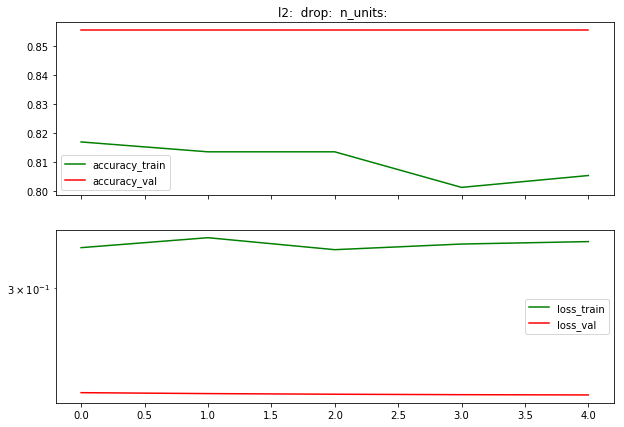

==== Test ===



====================  AAPL  trend:  -35   0  ==================== 


Epochs:  0
==== Test ===



====================  AAPL  trend:  -28   0  ==================== 


Epochs:  0
==== Test ===



====================  AAPL  trend:  -7   0  ==================== 


Epochs:  12


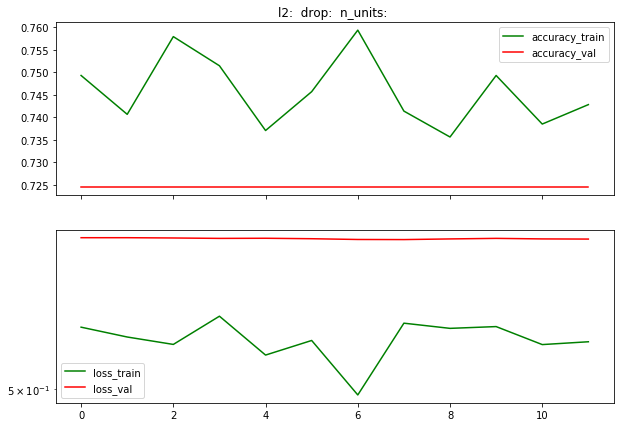

==== Test ===



====================  AAPL  trend:  -1   0  ==================== 


Epochs:  0
==== Test ===



====================  AAPL  trend:  1   2  ==================== 


Epochs:  13


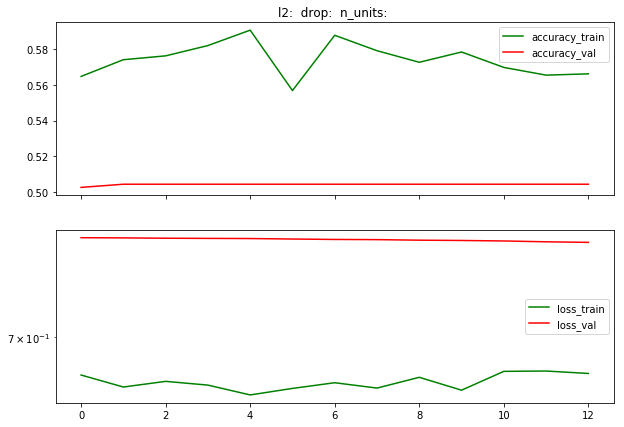

==== Test ===



====================  AAPL  trend:  1   8  ==================== 


Epochs:  0
==== Test ===



====================  AAPL  trend:  1   29  ==================== 


Epochs:  88


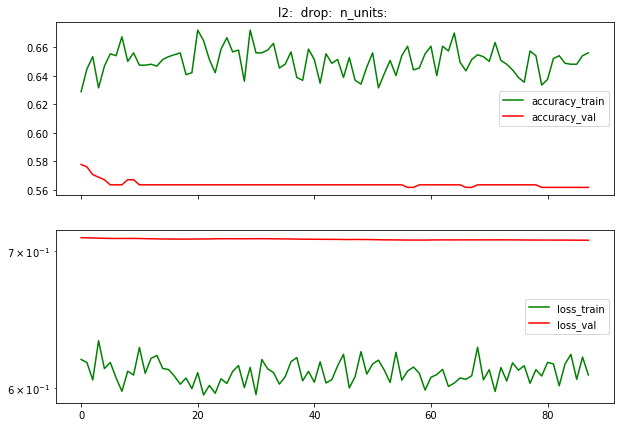

==== Test ===



====================  AAPL  trend:  1   36  ==================== 


Epochs:  183


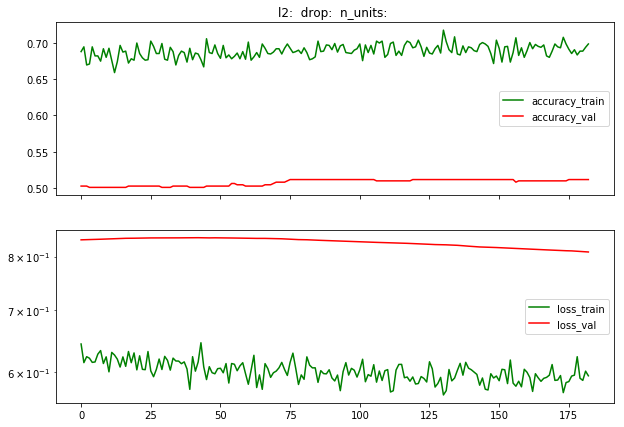

==== Test ===



====================  AAPL  trend:  1   50  ==================== 


Epochs:  0
==== Test ===



====================  AMZN  trend:  -48   0  ==================== 


Epochs:  0
==== Test ===



====================  AMZN  trend:  -35   0  ==================== 


Epochs:  8


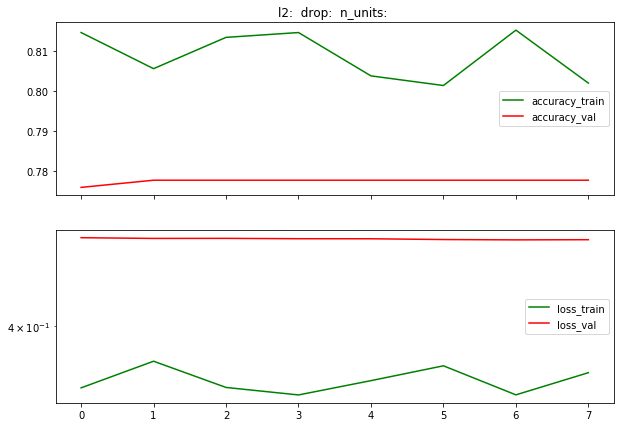

==== Test ===



====================  AMZN  trend:  -28   0  ==================== 


Epochs:  0
==== Test ===



====================  AMZN  trend:  -7   0  ==================== 


Epochs:  1


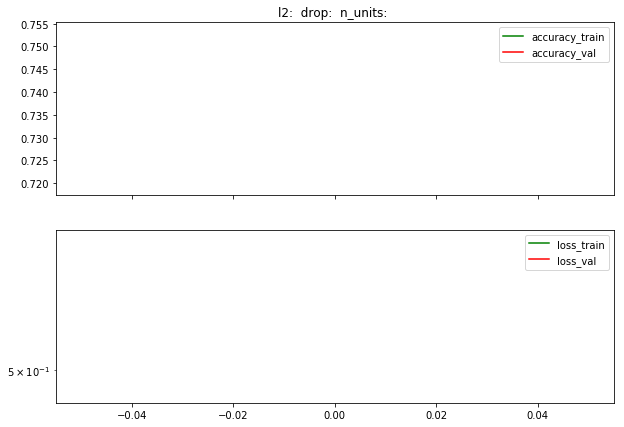

==== Test ===



====================  AMZN  trend:  -1   0  ==================== 


Epochs:  0
==== Test ===



====================  AMZN  trend:  1   2  ==================== 


Epochs:  0
==== Test ===



====================  AMZN  trend:  1   8  ==================== 


Epochs:  3


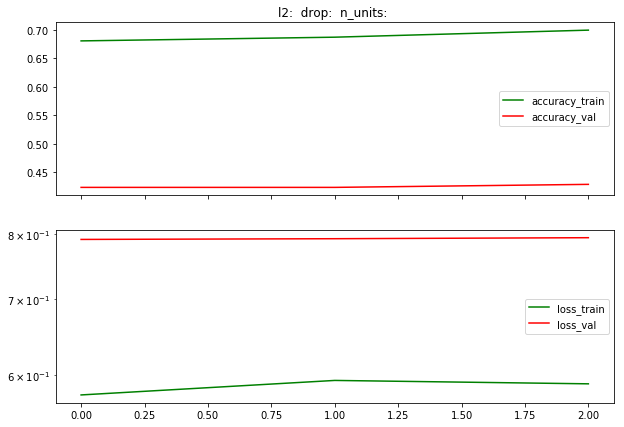

==== Test ===



====================  AMZN  trend:  1   29  ==================== 


Epochs:  0
==== Test ===



====================  AMZN  trend:  1   36  ==================== 


Epochs:  0
==== Test ===



====================  AMZN  trend:  1   50  ==================== 


Epochs:  0
==== Test ===



====================  GOOGL  trend:  -48   0  ==================== 


Epochs:  29


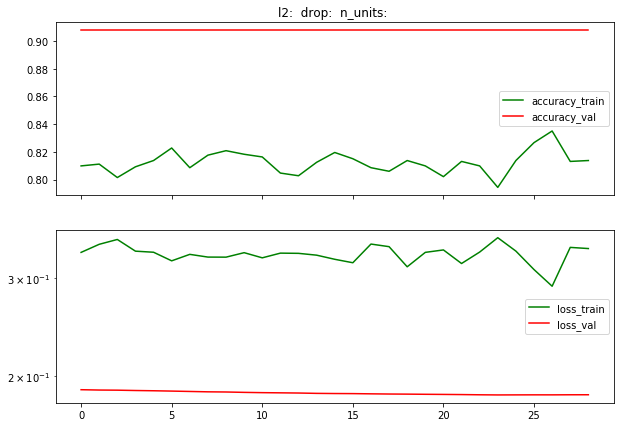

==== Test ===



====================  GOOGL  trend:  -35   0  ==================== 


Epochs:  0
==== Test ===



====================  GOOGL  trend:  -28   0  ==================== 


Epochs:  0
==== Test ===



====================  GOOGL  trend:  -7   0  ==================== 


Epochs:  61


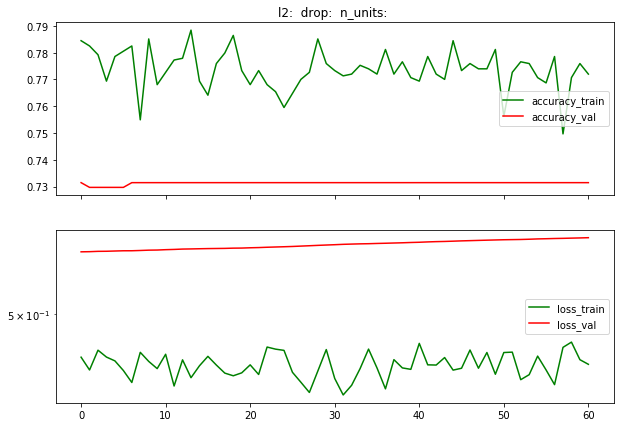

==== Test ===



====================  GOOGL  trend:  -1   0  ==================== 


Epochs:  0
==== Test ===



====================  GOOGL  trend:  1   2  ==================== 


Epochs:  0
==== Test ===



====================  GOOGL  trend:  1   8  ==================== 


Epochs:  196


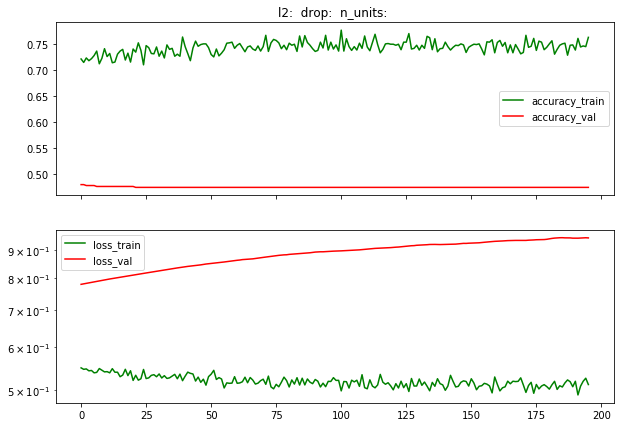

==== Test ===



====================  GOOGL  trend:  1   29  ==================== 


Epochs:  0
==== Test ===



====================  GOOGL  trend:  1   36  ==================== 


Epochs:  0
==== Test ===



====================  GOOGL  trend:  1   50  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  -48   0  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  -35   0  ==================== 


Epochs:  6


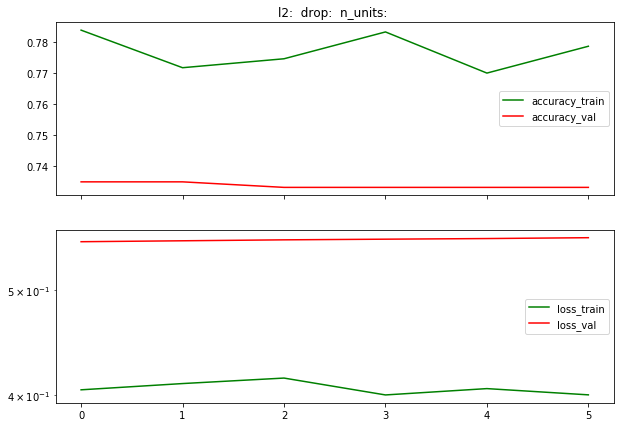

==== Test ===



====================  MSFT  trend:  -28   0  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  -7   0  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  -1   0  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  1   2  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  1   8  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  1   29  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  1   36  ==================== 


Epochs:  0
==== Test ===



====================  MSFT  trend:  1   50  ==================== 


Epochs:  0
==== Test ===



====================  FB  trend:  -48   0  ==================== 


Epochs:  111


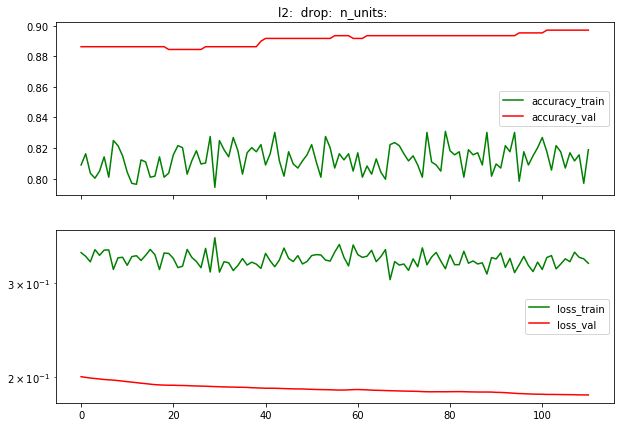

==== Test ===



====================  FB  trend:  -35   0  ==================== 


Epochs:  0
==== Test ===



====================  FB  trend:  -28   0  ==================== 


Epochs:  19


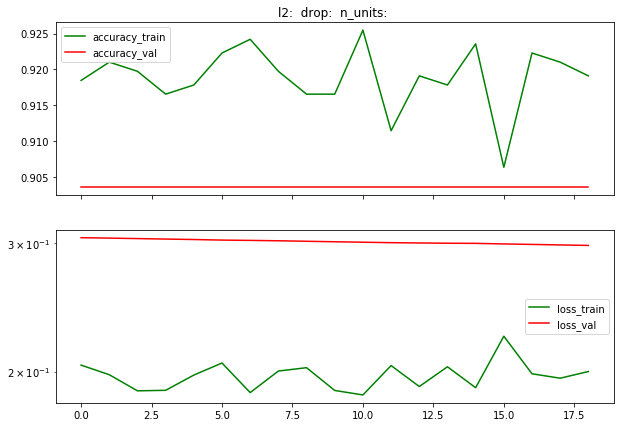

==== Test ===



====================  FB  trend:  -7   0  ==================== 


Epochs:  19


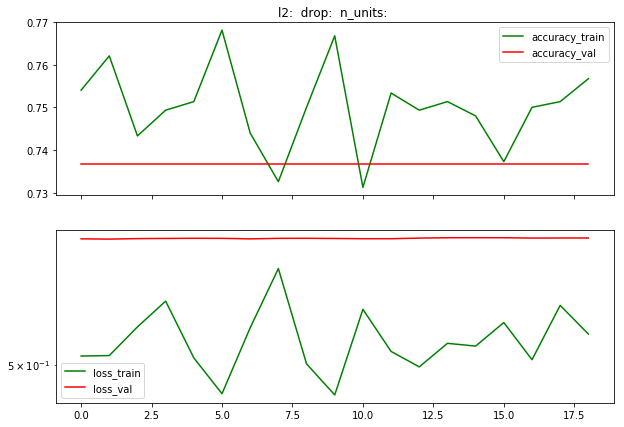

==== Test ===



====================  FB  trend:  -1   0  ==================== 


Epochs:  0
==== Test ===



====================  FB  trend:  1   2  ==================== 


Epochs:  192


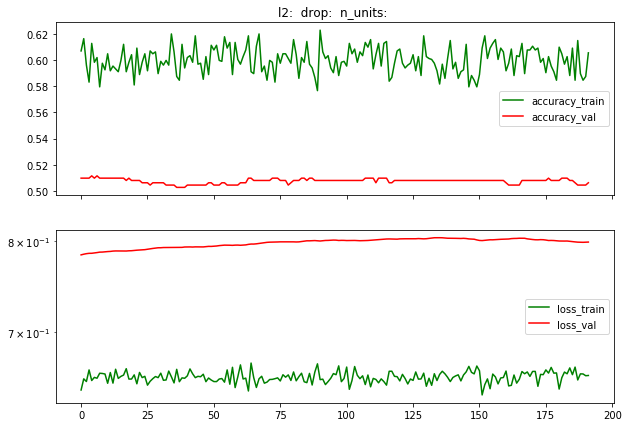

==== Test ===



====================  FB  trend:  1   8  ==================== 


Epochs:  0
==== Test ===



====================  FB  trend:  1   29  ==================== 


Epochs:  0
==== Test ===



====================  FB  trend:  1   36  ==================== 


Epochs:  10


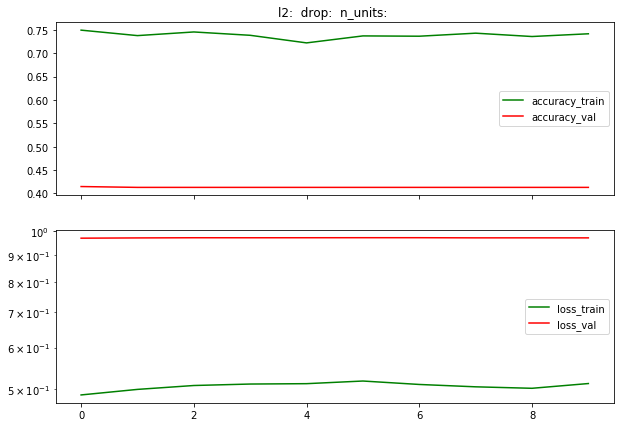

==== Test ===



====================  FB  trend:  1   50  ==================== 


Epochs:  15


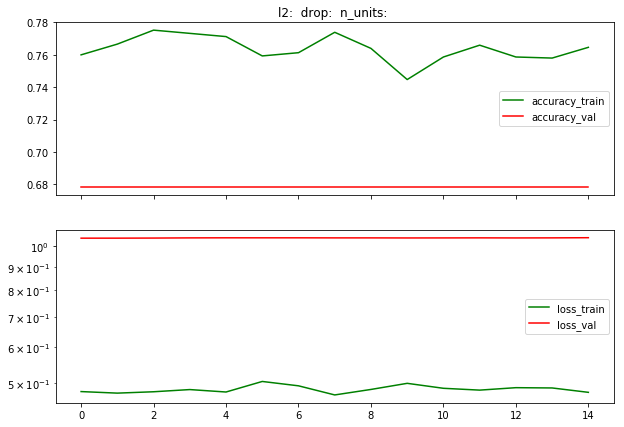

==== Test ===



====================  INTC  trend:  -48   0  ==================== 


Epochs:  0
==== Test ===



====================  INTC  trend:  -35   0  ==================== 


Epochs:  62


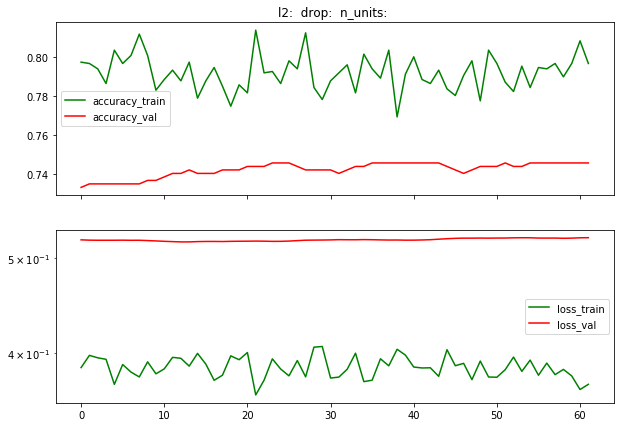

==== Test ===



====================  INTC  trend:  -28   0  ==================== 


Epochs:  1


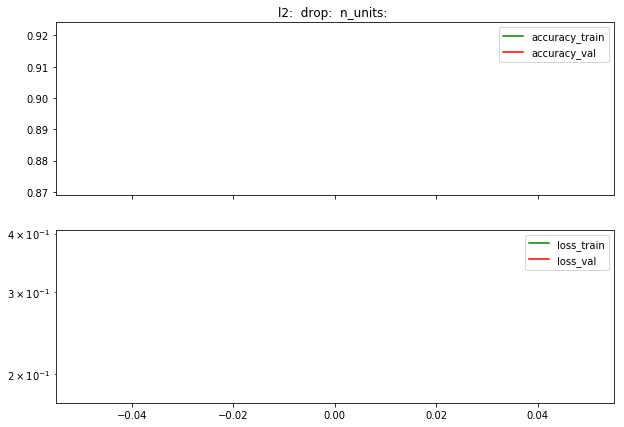

==== Test ===



====================  INTC  trend:  -7   0  ==================== 


Epochs:  0
==== Test ===



====================  INTC  trend:  -1   0  ==================== 


Epochs:  0
==== Test ===



====================  INTC  trend:  1   2  ==================== 


Epochs:  38


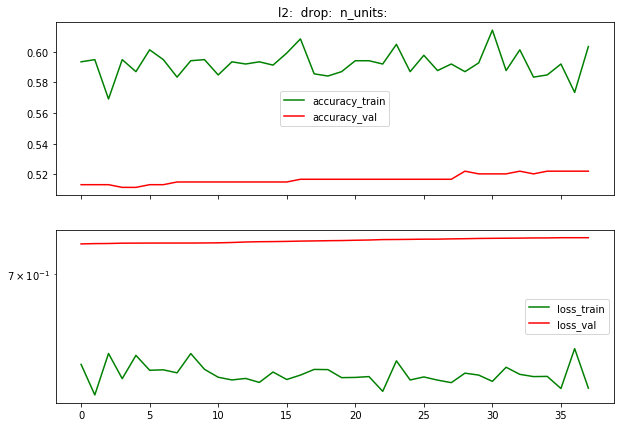

==== Test ===



====================  INTC  trend:  1   8  ==================== 


Epochs:  18


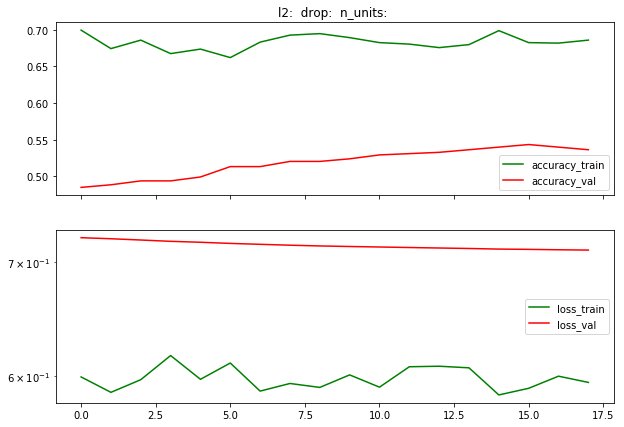

==== Test ===



====================  INTC  trend:  1   29  ==================== 


Epochs:  88


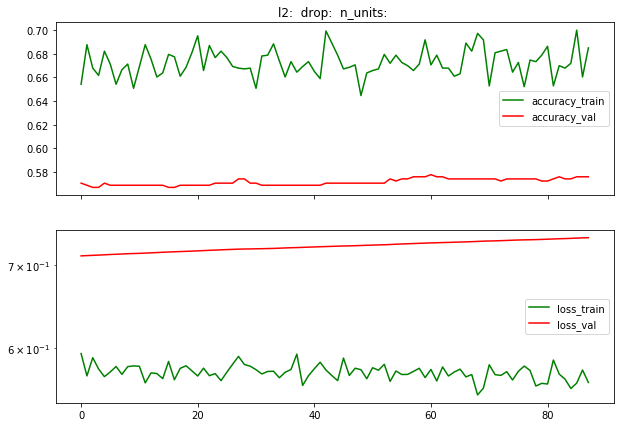

==== Test ===



====================  INTC  trend:  1   36  ==================== 


Epochs:  1


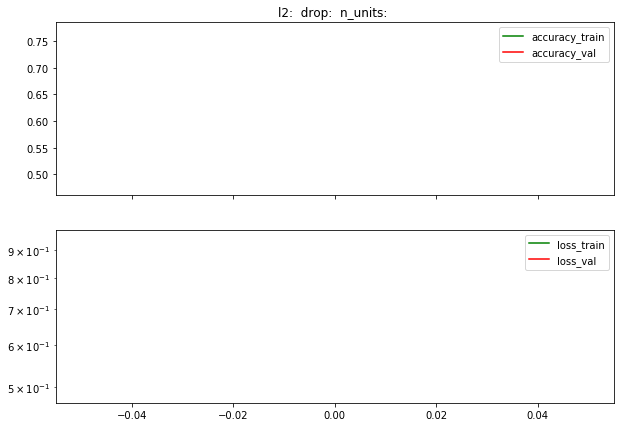

==== Test ===



====================  INTC  trend:  1   50  ==================== 


Epochs:  78


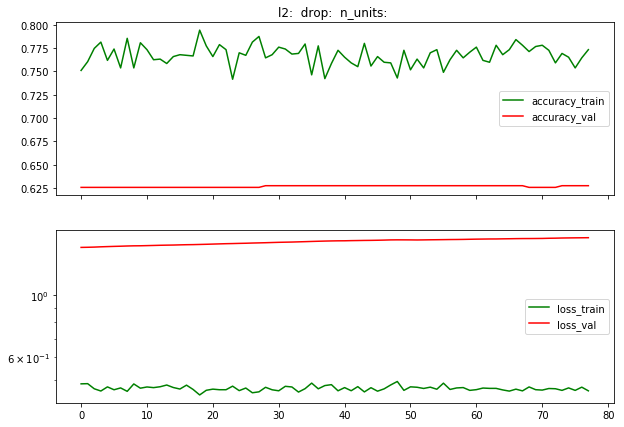

==== Test ===



====================  CSCO  trend:  -48   0  ==================== 


Epochs:  0
==== Test ===



====================  CSCO  trend:  -35   0  ==================== 


Epochs:  110


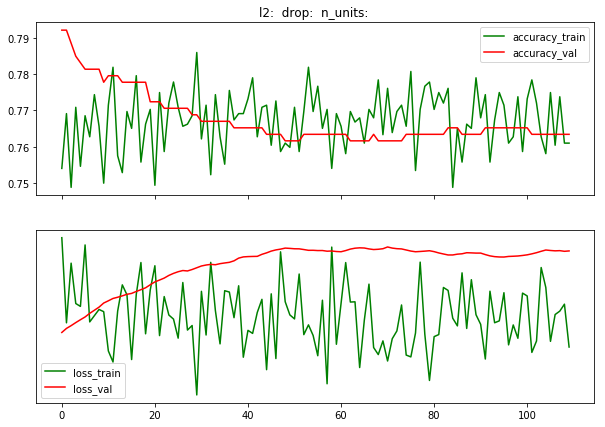

==== Test ===



====================  CSCO  trend:  -28   0  ==================== 


Epochs:  0
==== Test ===



====================  CSCO  trend:  -7   0  ==================== 


Epochs:  0
==== Test ===



====================  CSCO  trend:  -1   0  ==================== 


Epochs:  14


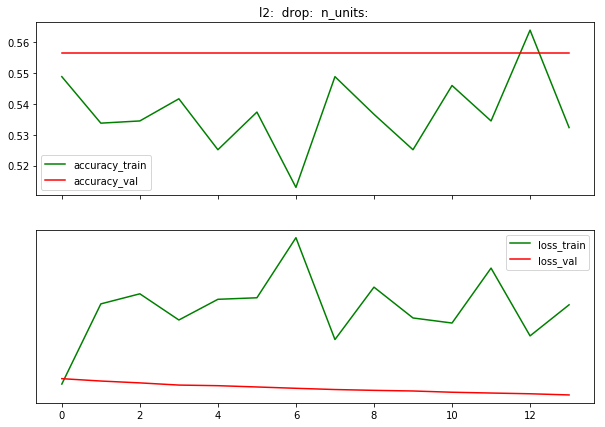

==== Test ===



====================  CSCO  trend:  1   2  ==================== 


Epochs:  22


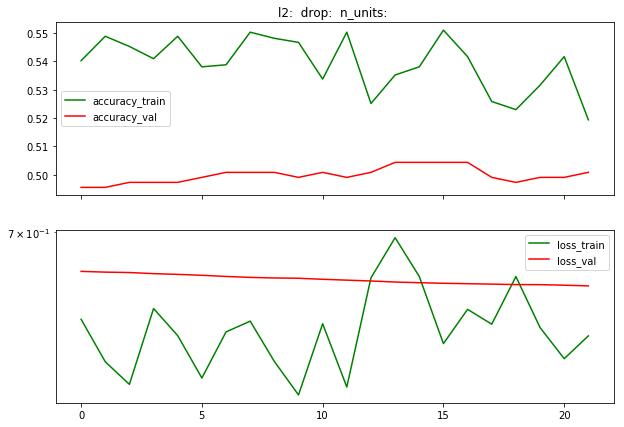

==== Test ===



====================  CSCO  trend:  1   8  ==================== 


Epochs:  0
==== Test ===



====================  CSCO  trend:  1   29  ==================== 


Epochs:  14


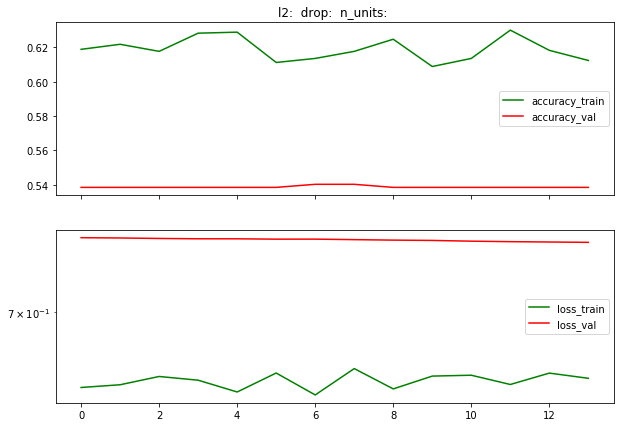

==== Test ===



====================  CSCO  trend:  1   36  ==================== 


Epochs:  101


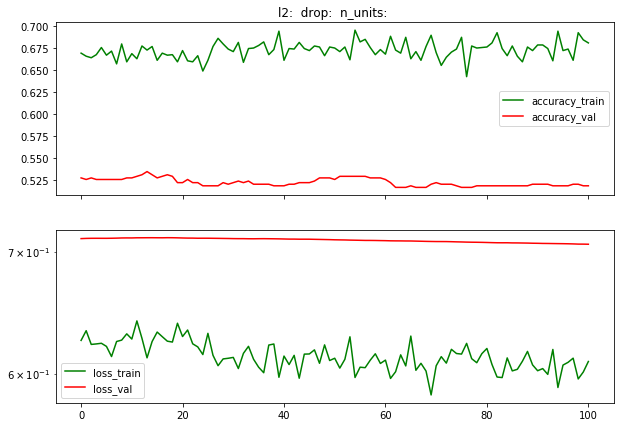

==== Test ===



====================  CSCO  trend:  1   50  ==================== 


Epochs:  191


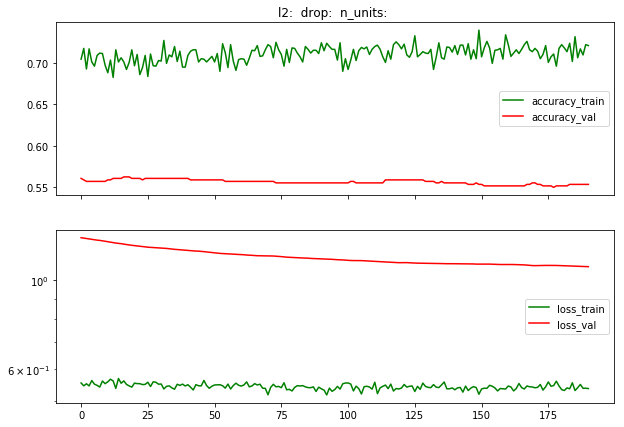

==== Test ===



====================  CMCSA  trend:  -48   0  ==================== 


Epochs:  4


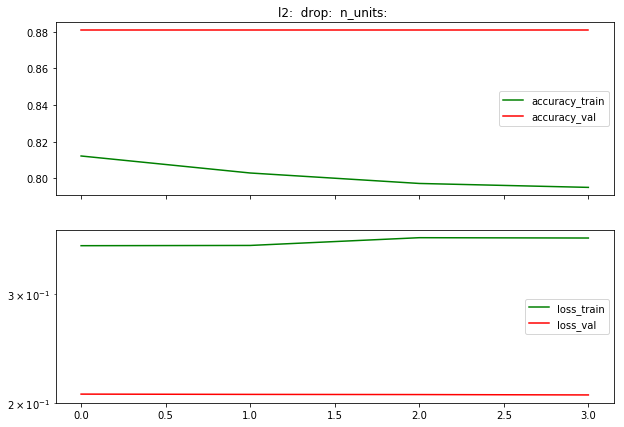

==== Test ===



====================  CMCSA  trend:  -35   0  ==================== 


Epochs:  0
==== Test ===



====================  CMCSA  trend:  -28   0  ==================== 


Epochs:  0
==== Test ===



====================  CMCSA  trend:  -7   0  ==================== 


Epochs:  0
==== Test ===



====================  CMCSA  trend:  -1   0  ==================== 


Epochs:  34


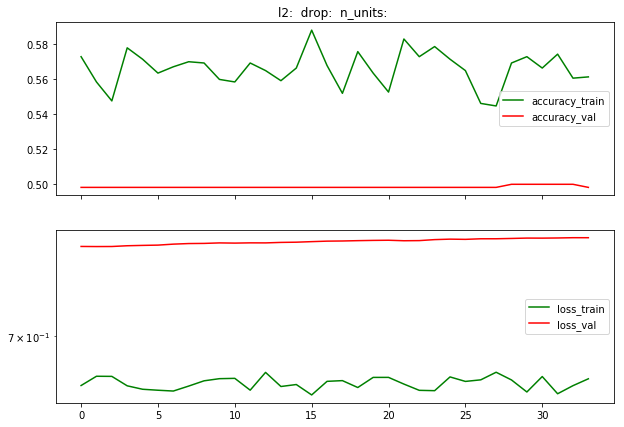

==== Test ===



====================  CMCSA  trend:  1   2  ==================== 


Epochs:  13


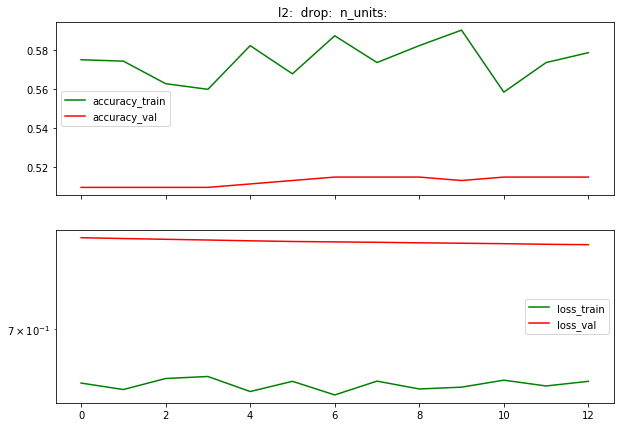

==== Test ===



====================  CMCSA  trend:  1   8  ==================== 


Epochs:  195


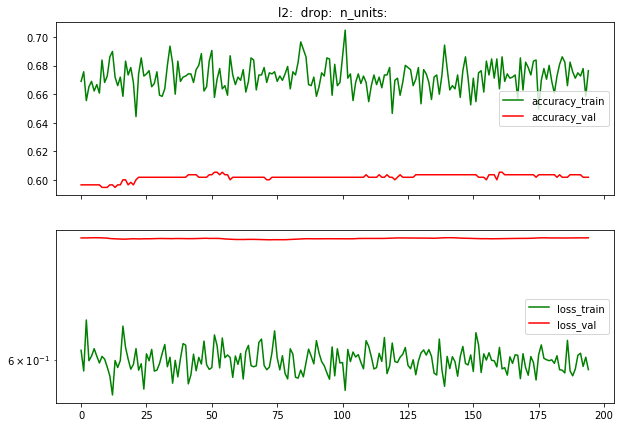

==== Test ===



====================  CMCSA  trend:  1   29  ==================== 


Epochs:  0
==== Test ===



====================  CMCSA  trend:  1   36  ==================== 


Epochs:  0
==== Test ===



====================  CMCSA  trend:  1   50  ==================== 


Epochs:  144


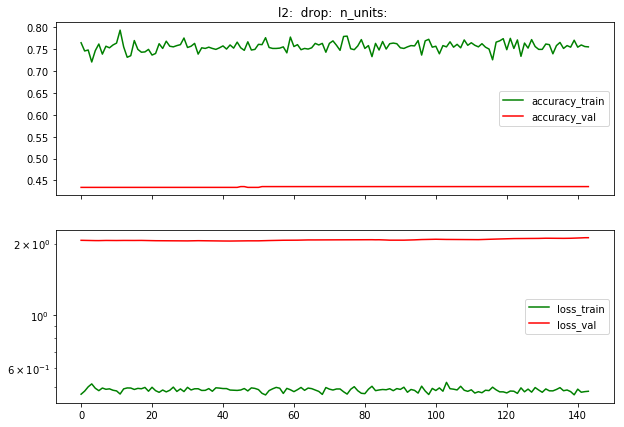

==== Test ===



====================  NVDA  trend:  -48   0  ==================== 


Epochs:  0
==== Test ===



====================  NVDA  trend:  -35   0  ==================== 


Epochs:  12


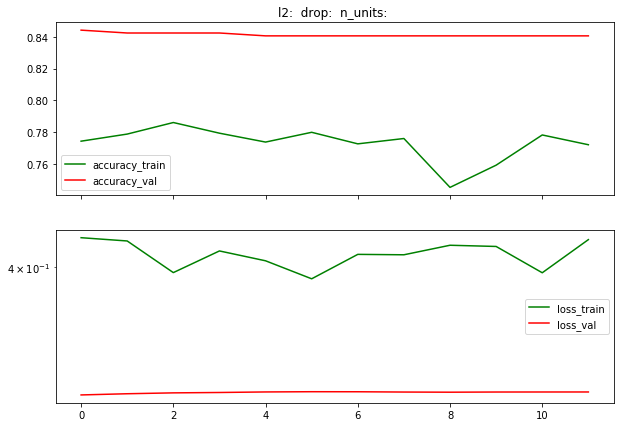

==== Test ===



====================  NVDA  trend:  -28   0  ==================== 


Epochs:  0
==== Test ===



====================  NVDA  trend:  -7   0  ==================== 


Epochs:  190


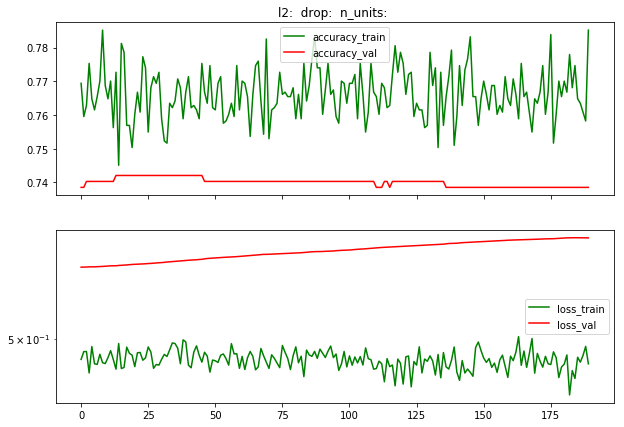

==== Test ===



====================  NVDA  trend:  -1   0  ==================== 


Epochs:  0
==== Test ===



====================  NVDA  trend:  1   2  ==================== 


Epochs:  0
==== Test ===



====================  NVDA  trend:  1   8  ==================== 


Epochs:  65


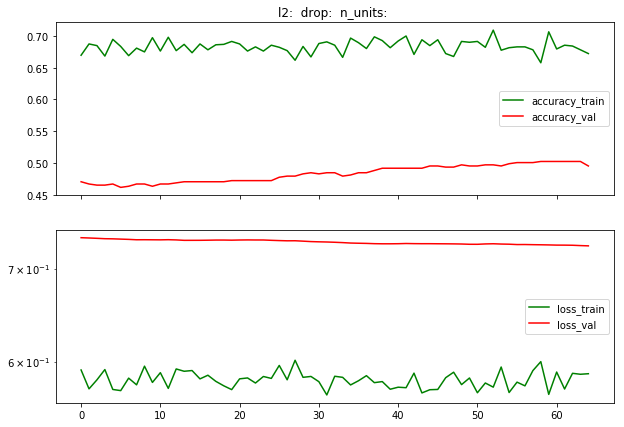

==== Test ===



====================  NVDA  trend:  1   29  ==================== 


Epochs:  72


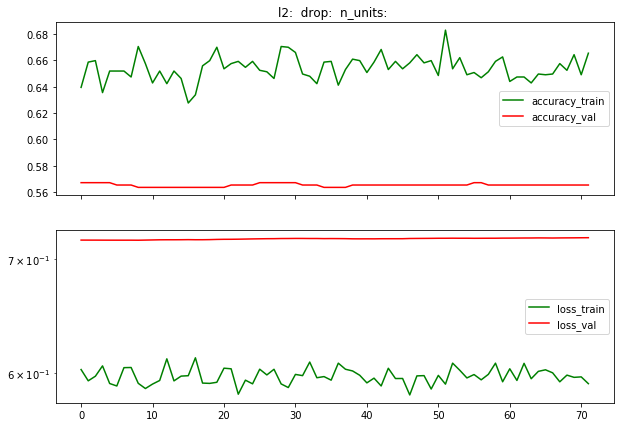

==== Test ===



====================  NVDA  trend:  1   36  ==================== 


Epochs:  92


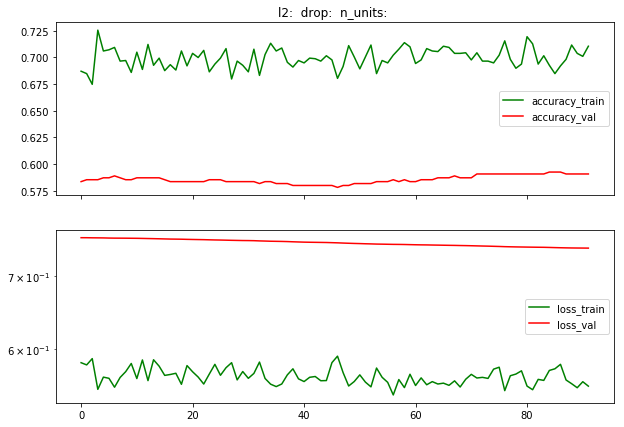

==== Test ===



====================  NVDA  trend:  1   50  ==================== 


Epochs:  95


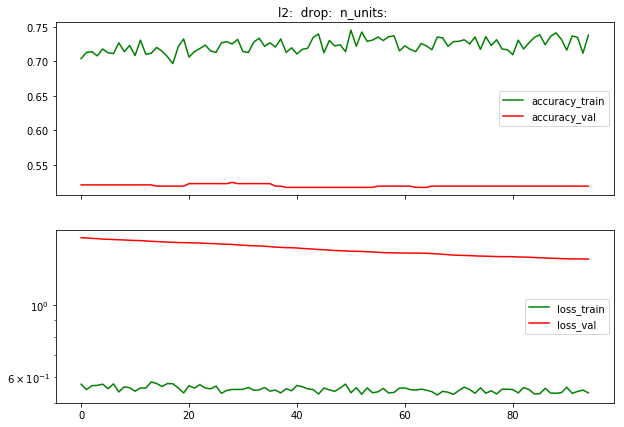

==== Test ===



====================  NFLX  trend:  -48   0  ==================== 


Epochs:  0
==== Test ===



====================  NFLX  trend:  -35   0  ==================== 


Epochs:  45


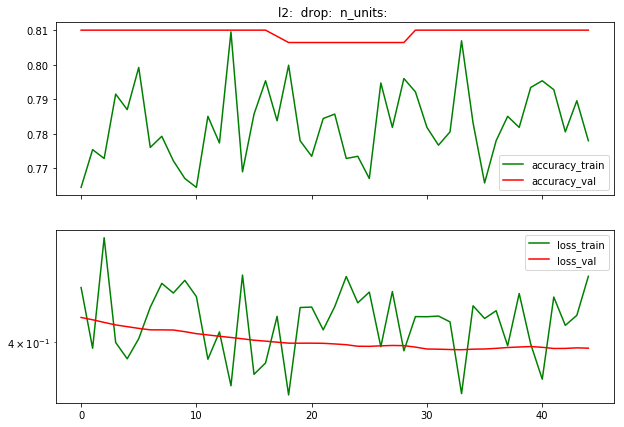

==== Test ===



====================  NFLX  trend:  -28   0  ==================== 


Epochs:  0
==== Test ===



====================  NFLX  trend:  -7   0  ==================== 


Epochs:  0
==== Test ===



====================  NFLX  trend:  -1   0  ==================== 


Epochs:  0
==== Test ===



====================  NFLX  trend:  1   2  ==================== 


Epochs:  86


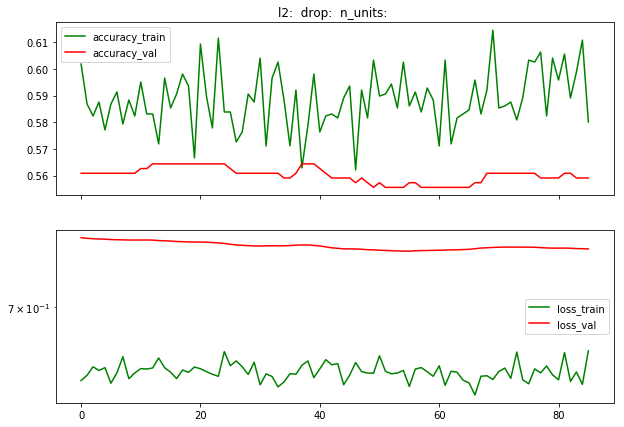

==== Test ===



====================  NFLX  trend:  1   8  ==================== 


Epochs:  0
==== Test ===



====================  NFLX  trend:  1   29  ==================== 


Epochs:  11


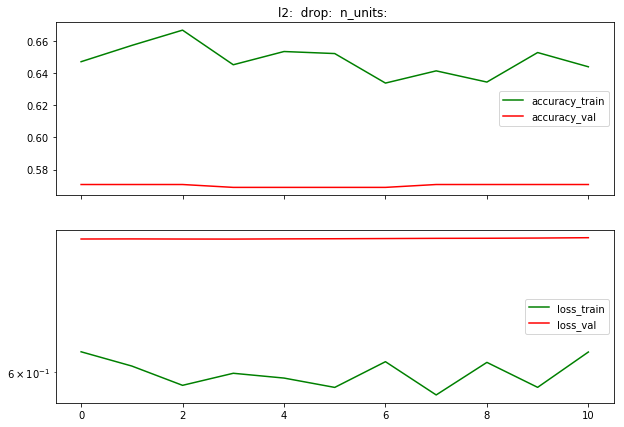

==== Test ===



====================  NFLX  trend:  1   36  ==================== 


Epochs:  67


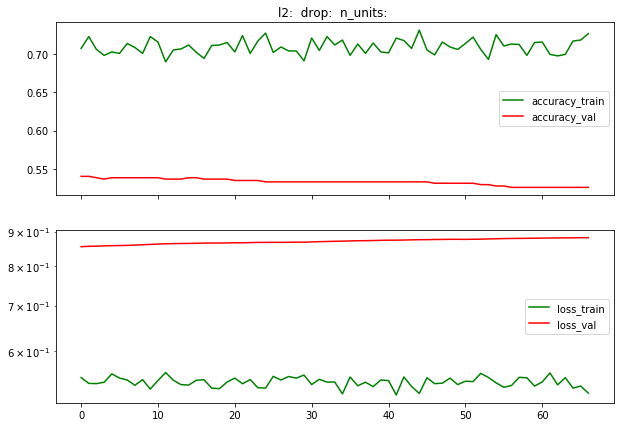

==== Test ===



====================  NFLX  trend:  1   50  ==================== 


Epochs:  196


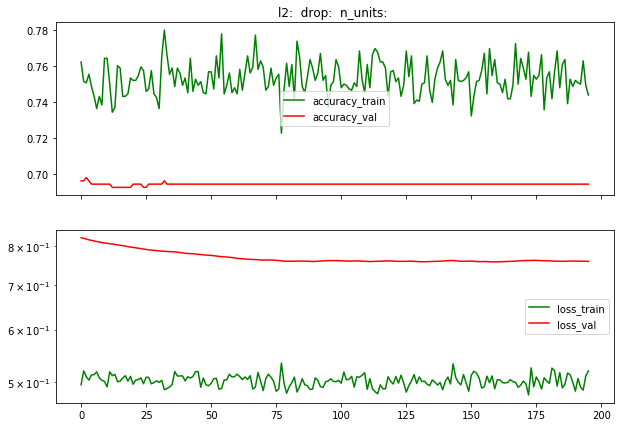

==== Test ===


In [11]:
for ticker in tickers:
    for (init, finish) in TREND_WINDOWs:
        print('\n\n\n==================== ',ticker,' trend: ',init,' ',finish, ' ==================== \n\n')
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        (x_tv,y_tv) = smote(x_tv,y_tv)
        nn_model = get_pretrained_model(init, finish)
        best_epochs = best_num_epoch(x_tv,y_tv)
        print('Epochs: ',best_epochs)
        if best_epochs > 0:
            history = nn_model.fit(x_tv, y_tv, epochs = best_epochs, batch_size =256, verbose=0,
                               validation_data=(x_test, y_test),shuffle=True)
            plot_hystory(history,'','','')  
            
        y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
        nn_model.save_weights('fineTuning_weights/nn_model_finetuned_weights_'+ticker+'_REGR_'+str(init)+'_'+str(finish)+'.h5')   
        np.savetxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', y_pred, delimiter=",")

        print('==== Test ===')

AAPL   1   2


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AAPL   1   8
AAPL   1   29
AAPL   1   36
AAPL   1   50
AMZN   1   2
AMZN   1   8
AMZN   1   29
AMZN   1   36
AMZN   1   50
GOOGL   1   2
GOOGL   1   8
GOOGL   1   29
GOOGL   1   36
GOOGL   1   50
MSFT   1   2
MSFT   1   8
MSFT   1   29
MSFT   1   36
MSFT   1   50
FB   1   2
FB   1   8
FB   1   29
FB   1   36
FB   1   50
INTC   1   2
INTC   1   8
INTC   1   29
INTC   1   36
INTC   1   50
CSCO   1   2
CSCO   1   8
CSCO   1   29
CSCO   1   36
CSCO   1   50
CMCSA   1   2
CMCSA   1   8
CMCSA   1   29
CMCSA   1   36
CMCSA   1   50
NVDA   1   2
NVDA   1   8
NVDA   1   29
NVDA   1   36
NVDA   1   50
NFLX   1   2
NFLX   1   8
NFLX   1   29
NFLX   1   36
NFLX   1   50


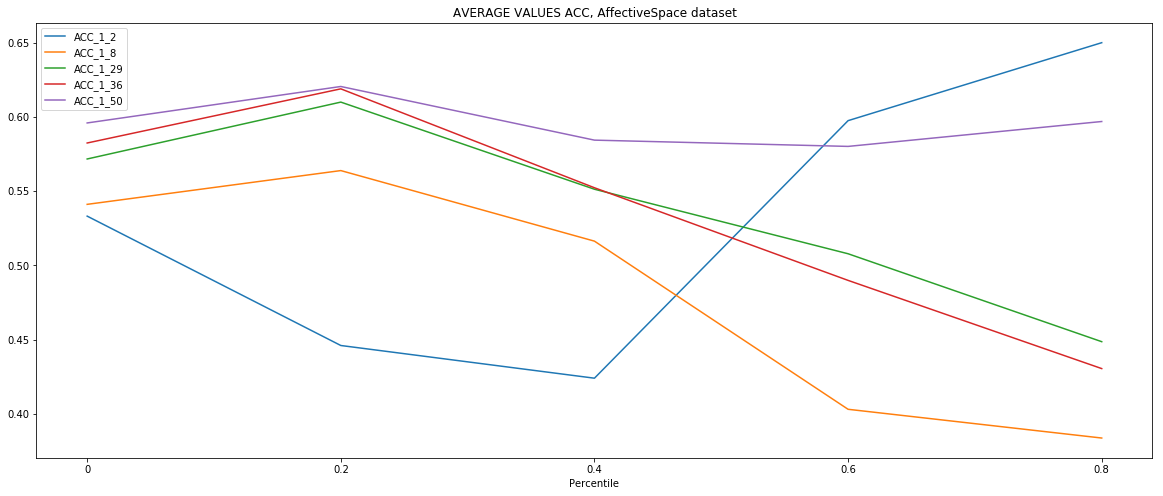

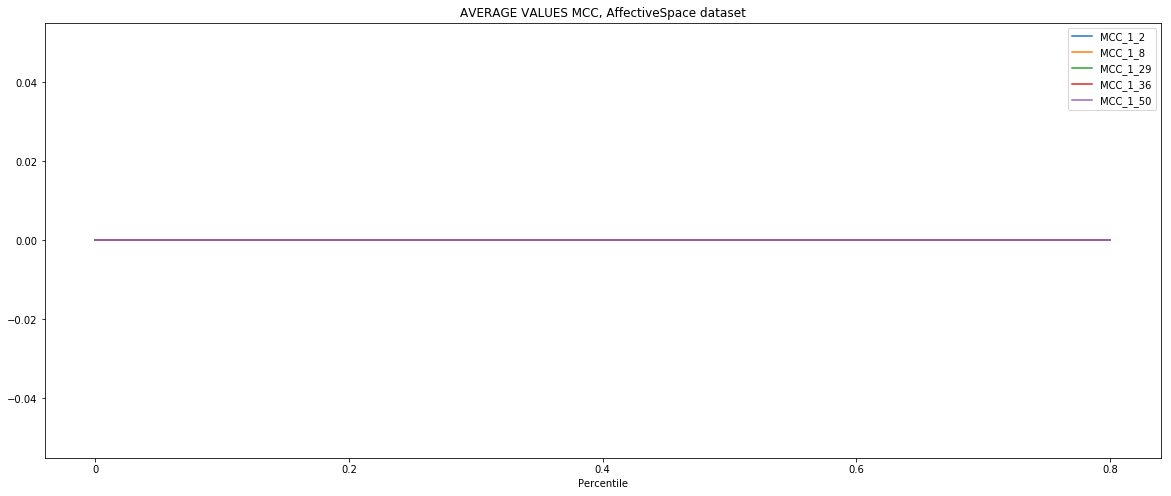

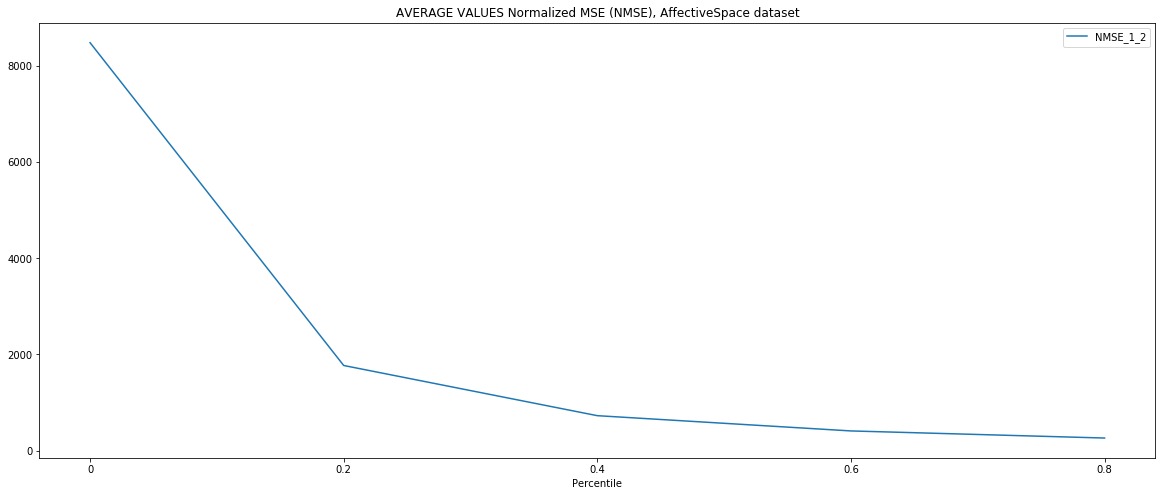

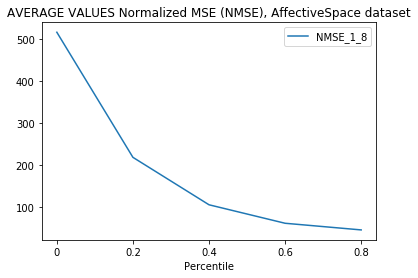

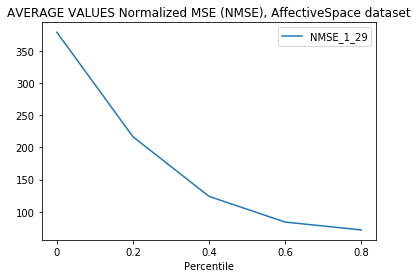

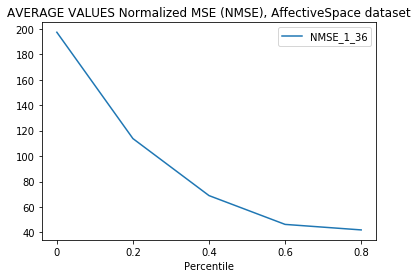

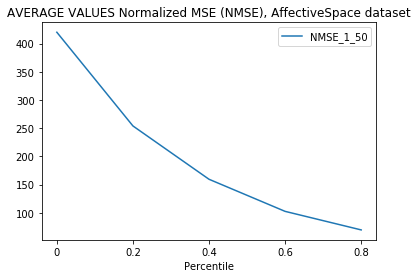

In [17]:
#Predictions Percentile on fluctuations
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg_weight = np.zeros([len(FUTURE_WINDOWs), 5])

for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        y_test = ds.cum_ret_test
        
        thresholds = np.linspace(0, max(np.absolute(y_test)), num=6)[:-1]
        for t in range(0,5):
            threshold = thresholds[t]
            y_over_th = []
            y_pred_over_th = []
            weights_over_th = []
            for y, y_p in zip(y_test, y_pred):
                if(abs(y)> threshold):
                    y_over_th.append(y)
                    y_pred_over_th.append(y_p)
            mse = MSE(y_over_th,y_pred_over_th)
            nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
            mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
            acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
            MSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mse/len(tickers)
            NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= nmse/len(tickers)
            ACCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= acc/len(tickers)
            MCCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mcc/len(tickers)

    labels = [0,0.2,.4,.6,.8]
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(ACCs_avg[i,:], label='ACC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES ACC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(MCCs_avg[i,:], label='MCC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES MCC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(NMSEs_avg[i,:], label='NMSE_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('AVERAGE VALUES Normalized MSE (NMSE), '+str(kind_of_dataset)+' dataset')
    plt.legend()
    plt.show() 

np.savetxt('ACC_percentile_on_fluctuations.csv', ACCs_avg, delimiter=",")
np.savetxt('MCC_percentile_on_fluctuations.csv', MCCs_avg, delimiter=",")

AAPL   1   2


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AAPL   1   8
AAPL   1   29
AAPL   1   36
AAPL   1   50
AMZN   1   2
AMZN   1   8
AMZN   1   29
AMZN   1   36
AMZN   1   50
GOOGL   1   2
GOOGL   1   8
GOOGL   1   29
GOOGL   1   36
GOOGL   1   50
MSFT   1   2
MSFT   1   8
MSFT   1   29
MSFT   1   36
MSFT   1   50
FB   1   2
FB   1   8
FB   1   29
FB   1   36
FB   1   50
INTC   1   2
INTC   1   8
INTC   1   29
INTC   1   36
INTC   1   50
CSCO   1   2
CSCO   1   8
CSCO   1   29
CSCO   1   36
CSCO   1   50
CMCSA   1   2
CMCSA   1   8
CMCSA   1   29
CMCSA   1   36
CMCSA   1   50
NVDA   1   2
NVDA   1   8
NVDA   1   29
NVDA   1   36
NVDA   1   50
NFLX   1   2
NFLX   1   8
NFLX   1   29
NFLX   1   36
NFLX   1   50


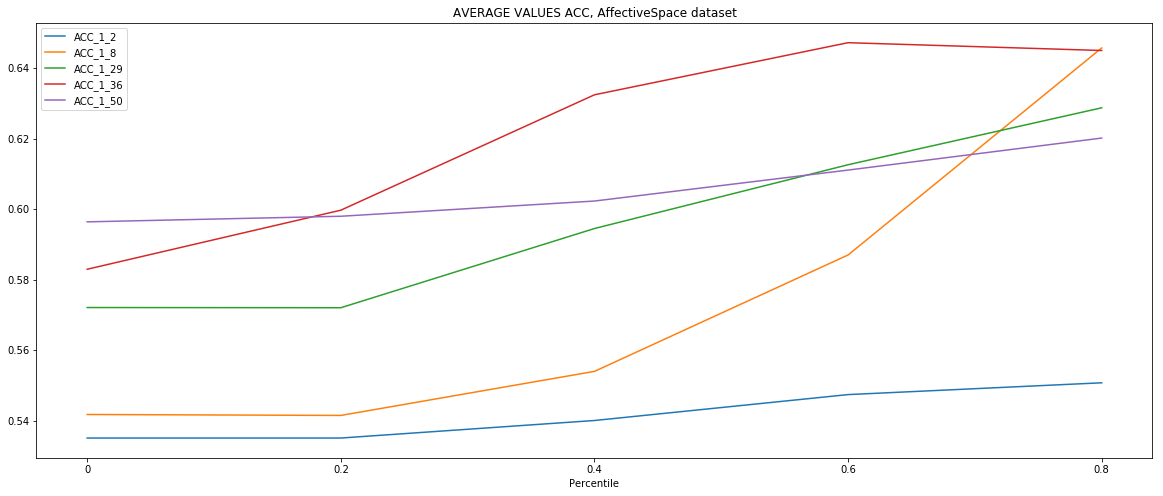

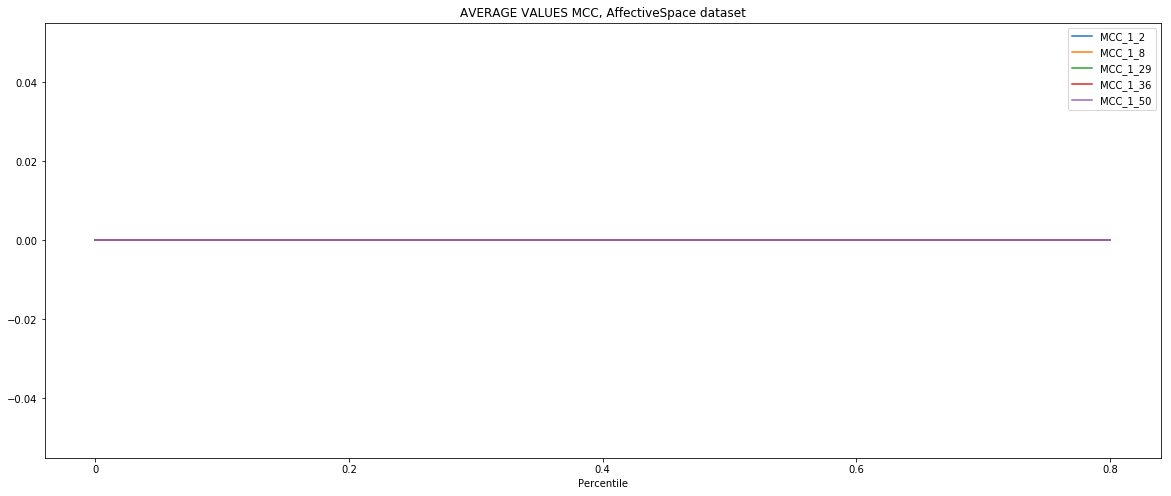

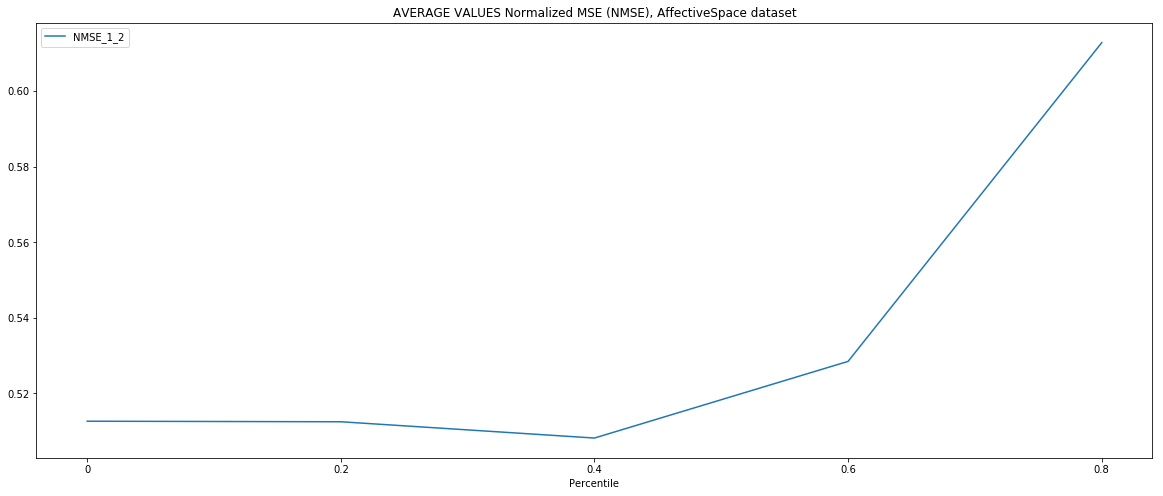

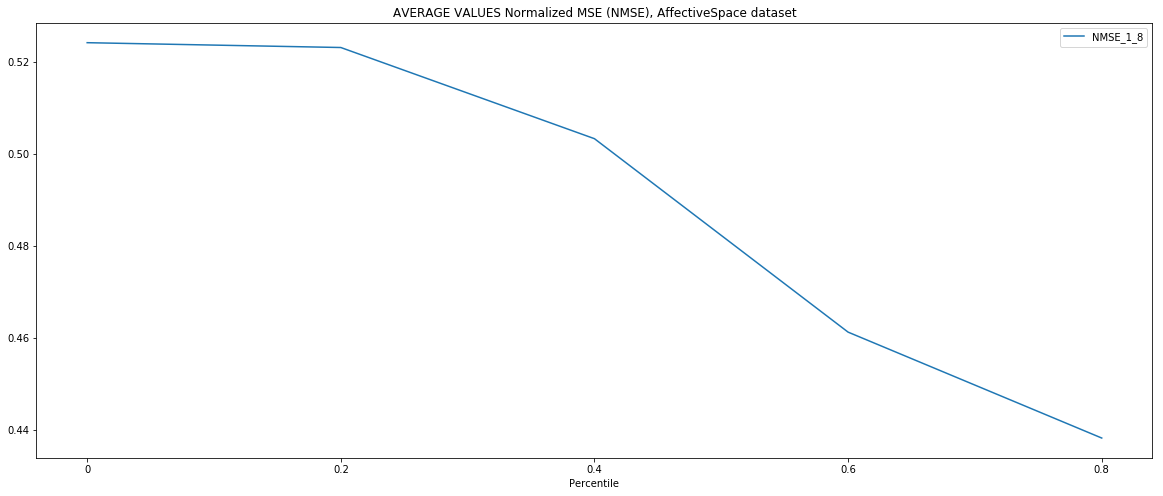

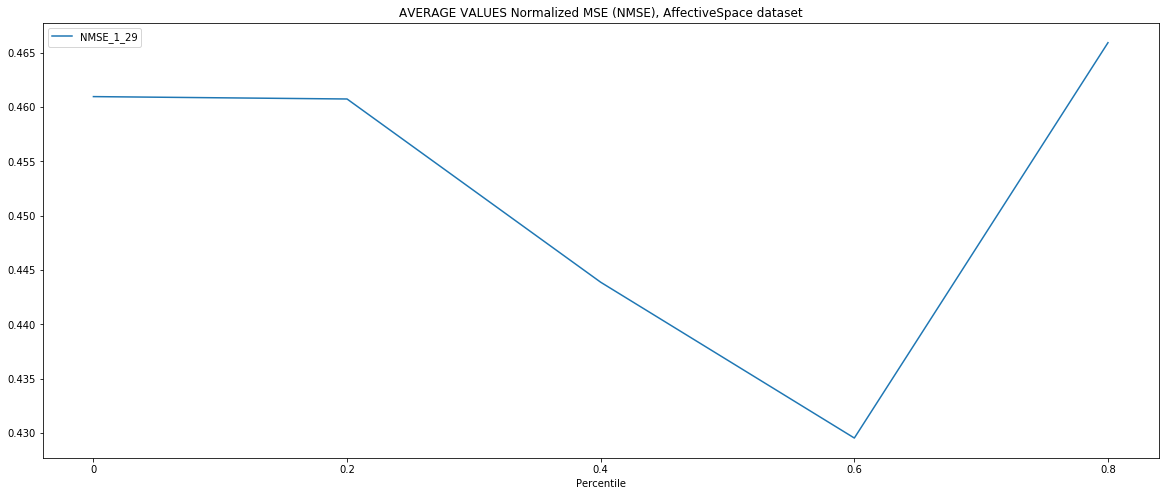

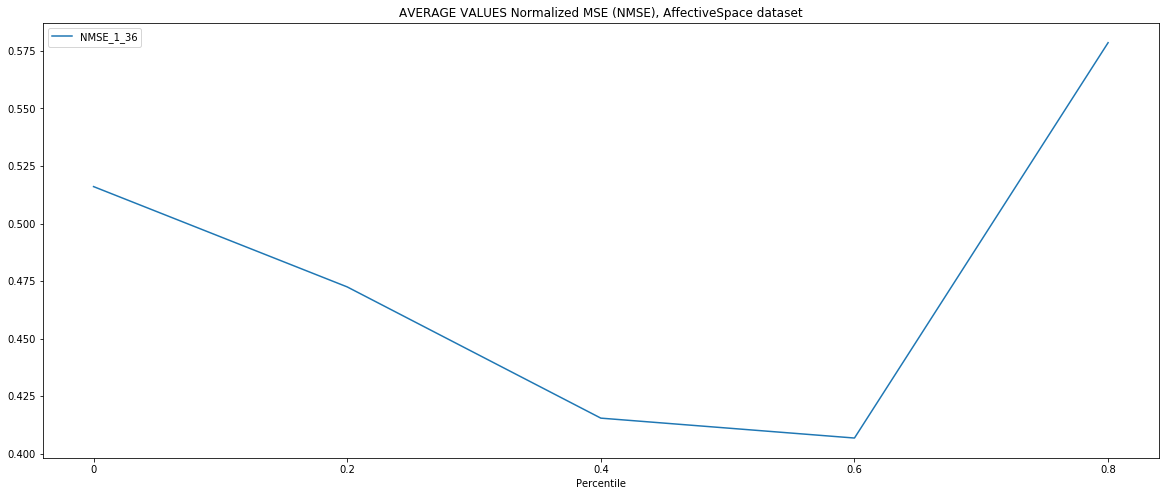

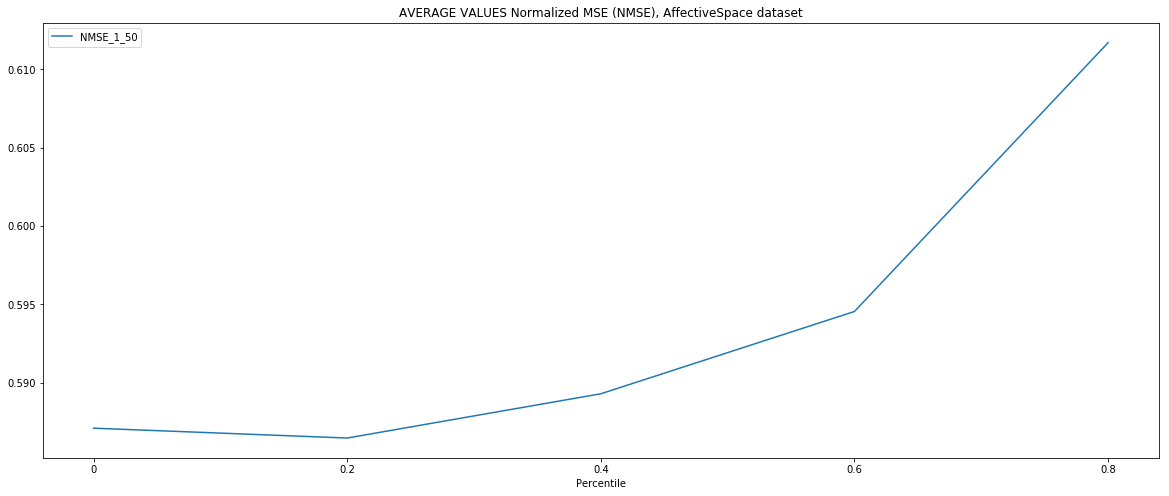

In [16]:
#Predictions percentile on predictions
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg_weight = np.zeros([len(FUTURE_WINDOWs), 5])

for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        
        thresholds = np.linspace(0, max(np.absolute(y_pred)), num=6)[:-1]
        for t in range(0,5):
            threshold = thresholds[t]
            y_over_th = []
            y_pred_over_th = []
            for y, y_p in zip(y_test, y_pred):
                if(abs(y_p)> threshold):
                    y_over_th.append(y)
                    y_pred_over_th.append(y_p)
            nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
            mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
            acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
            NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= nmse/len(tickers)
            ACCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= acc/len(tickers)
            MCCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mcc/len(tickers)

    labels = [0,0.2,.4,.6,.8]
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(ACCs_avg[i,:], label='ACC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES ACC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(MCCs_avg[i,:], label='MCC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES MCC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(20,8))
    plt.plot(NMSEs_avg[i,:], label='NMSE_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('AVERAGE VALUES Normalized MSE (NMSE), '+str(kind_of_dataset)+' dataset')
    plt.legend()
    plt.show() 

np.savetxt('ACC_percentile_on_predictions.csv', ACCs_avg, delimiter=",")
np.savetxt('MCC_percentile_on_predictions.csv', MCCs_avg, delimiter=",")